In [1]:
#https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
import keras

Using TensorFlow backend.


In [3]:
K.categorical_crossentropy?

In [4]:
%matplotlib inline

In [5]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

#### Maximum Likelihood

Maximize the probability of each $\vec x$ in the training set:

$$
 p(\vec x^{(i)}) = \int_\mathcal Z p(\vec x^{(i)} \mid \vec z, \theta) p(\vec z) d\vec z
$$

Maximize: 
$$
  p_{\mathcal D_{train}}=\prod_i p(\vec x^{(i)}) 
$$

Equivalent to minimize:
$$
  - \log p_{\mathcal D_{train}}= - \sum_i \log p(\vec x^{(i)}) 
$$


#### Output distribution

$$
P(\vec x \mid \vec z; \theta) = \mathcal N\left(\vec x \mid f(\vec z; \theta), \sigma^2 \cdot I\right)
$$

with
- $\mathcal N$: Gaussian distribution
- $I$: Identity matrix
- $f(\vec z; \theta)$
- $\sigma^2$: Varianz (scalar); Hyperparameter

#### Encoder for training

Approximation $q(\vec z \mid \vec x)$ for true $p(\vec z \mid x)$: 

$$
 q(\vec z \mid \vec x) = \mathcal N \left( \vec z \mid \vec \mu(\vec x; \vartheta), \Sigma^2(\vec x; \vartheta) \right)
$$
with
 - $\vec \mu$: mean of multivariate Gaussian 
 - $\Sigma^2$: variances of multivariate Gaussian (restricted to a diagonal matrix)

In [6]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h) # exponentiation results in positive values

$$
\Sigma^2 = var = \exp(\log var) 
$$
$$
 \Sigma = \exp(\frac{1}{2} \log var)
$$

In [7]:
def sampling(args):
    z_mean, z_log_var = args
    # reparametrization trick
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              std=epsilon_std) # stddev -> std ??
    return z_mean + K.exp(z_log_var / 2) * epsilon


The approximation should be good in regions where $q(\vec z \mid \vec x )$ is relative high:

$$
KL \left( q(\vec z \mid \vec x ) \mid\mid  p(z\mid x) \right) = \mathbb E_{}
$$

$$
\log p(\vec x) - KL\left( q(\vec z \mid \vec x ) \mid\mid  p(\vec z\mid \vec x) \right) = 
  \mathbb E_{\vec z \sim Q} \left[ \log P(\vec x \mid \vec z)\right] - 
  KL \left[ Q(\vec z \mid \vec x) \mid \mid p(\vec z)\right]
$$

The right-hand side can be maximized via stochasitc gradient decent.

In [8]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

TypeError: random_normal() got an unexpected keyword argument 'std'

#### Decoder 

In [9]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


#### Loss

Kullback Leibler Loss:

$$
KL \left[ q(\vec z \mid \vec x) \mid \mid p(\vec z)\right]
$$

Both distribution are Gaussian:
 - $q(\vec z \mid \vec x) = \mathcal N \left( \vec \mu(\vec x; \vartheta), \Sigma^2(\vec x; \vartheta) \right)$
 - $p(\vec z) = \mathcal N \left( 0, I \right)$
 
So  
$$
KL \left[ q(\vec z \mid \vec x) \mid \mid p(\vec z)\right] = \frac{1}{2} 
\left( \text{tr} (\Sigma(\vec x))\ +\mu(\vec x) ^T \left( \mu(\vec x) - k - \log \det(\Sigma(\vec x) \right) \right)
$$

In [10]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    #kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)


In [11]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [83]:
vae.fit?

In [21]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 12s - loss: 149.7173 - val_loss: 151.9138
Epoch 2/100
60000/60000 [==============================] - 11s - loss: 149.6547 - val_loss: 152.1183
Epoch 3/100
60000/60000 [==============================] - 11s - loss: 149.5266 - val_loss: 151.9505
Epoch 4/100
60000/60000 [==============================] - 11s - loss: 149.4630 - val_loss: 151.6303
Epoch 5/100
60000/60000 [==============================] - 11s - loss: 149.3965 - val_loss: 151.7071
Epoch 6/100
60000/60000 [==============================] - 11s - loss: 149.3440 - val_loss: 151.5611
Epoch 7/100
60000/60000 [==============================] - 11s - loss: 149.2416 - val_loss: 151.9293
Epoch 8/100
60000/60000 [==============================] - 11s - loss: 149.1677 - val_loss: 151.6008
Epoch 9/100
60000/60000 [==============================] - 11s - loss: 149.0932 - val_loss: 151.5152
Epoch 10/100
60000/60000 [===============

In [22]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean) # z_log_var??

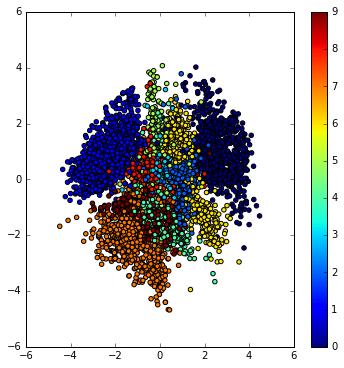

In [23]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

TODO: Compare with 
http://blog.fastforwardlabs.com/2016/08/12/introducing-variational-autoencoders-in-prose-and.html
    
Here a much better separation 

In [24]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [25]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))


In [26]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit


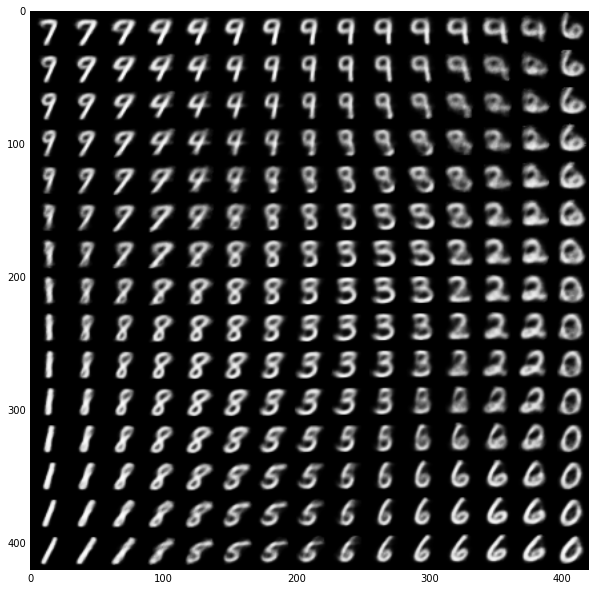

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()